In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # for plot styling
import numpy as np

### Introducing k-Means

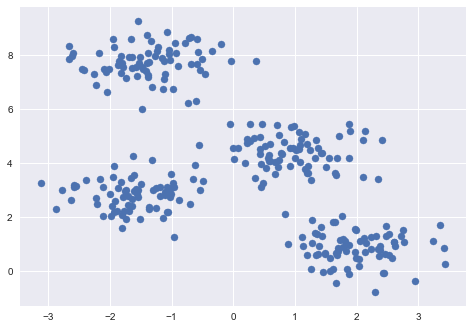

In [3]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, 
                      cluster_std=0.6, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

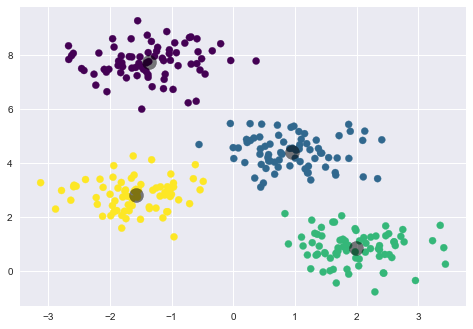

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### k-Means Algorithm: Expectation–Maximization
Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety
of contexts within data science. k-means is a particularly simple and easy-tounderstand
application of the algorithm, and we will walk through it briefly here. In
short, the expectation–maximization approach consists of the following procedure:
1. Guess some cluster centers
2. Repeat until converged 
    - E-Step: assign points to the nearest cluster center
    - M-Step: set the cluster centers to the mean

Here the “E-step” or “Expectation step” is so named because it involves updating our
expectation of which cluster each point belongs to. The “M-step” or “Maximization
step” is so named because it involves maximizing some fitness function that defines
the location of the cluster centers—in this case, that maximization is accomplished by
taking a simple mean of the data in each cluster.

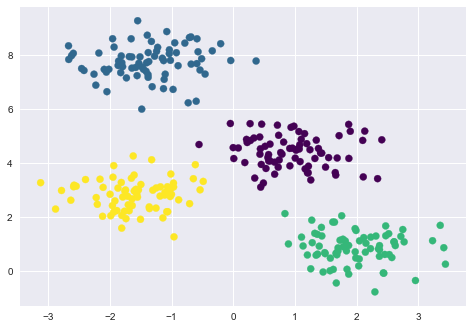

In [29]:
from sklearn.metrics import pairwise_distances_argmin

def find_cluster(X, n_clusters, rseed=2):
    # 1. Randomly choose cluster points
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) 
                                for i in range(n_clusters)])
        
        # 2c. check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
        
    return centers, labels

centers, labels = find_cluster(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
           s=50, cmap='viridis');

#### Caveats of expectation-maximization

_The gobally optimal result may not be achieved_

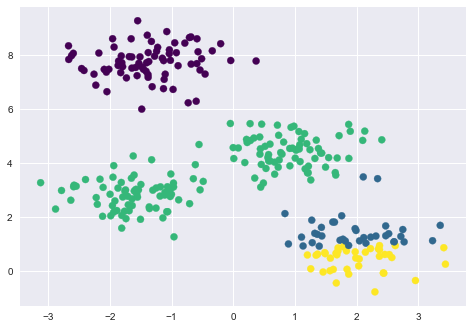

In [32]:
centers, labels = find_cluster(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
           s=50, cmap='viridis');

__But the sklearn version actually does a repeated initialisation under the hood  as set by the `n_init` parameter__

_The number of clusters must be selected beforehand_
Alternatively, you might use a more complicated clustering algorithm which has
a better quantitative measure of the fitness per number of clusters (e.g., Gaussian
mixture models; see “In Depth: Gaussian Mixture Models” on page 476) or which
can choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity
propagation, all available in the sklearn.cluster submodule).

_k-means is limited to linear cluster boundaries_

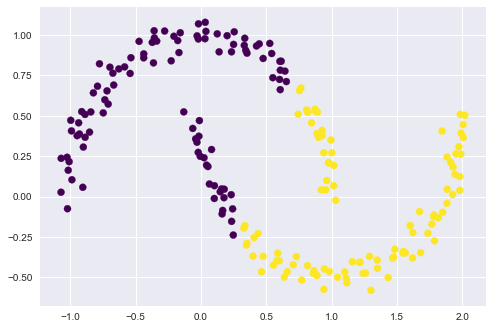

In [37]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
s=50, cmap='viridis');

One version of this kernelized k-means is implemented in Scikit-Learn within the
SpectralClustering estimator. It uses the graph of nearest neighbors to compute
a higher-dimensional representation of the data, and then assigns labels
using a k-means algorithm

C:\Users\Aroogz\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


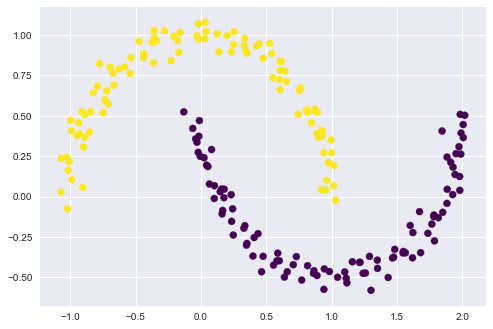

In [46]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2,
                          affinity='nearest_neighbors',
                          assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
s=50, cmap='viridis');

_K-means can be slow for large numbers of samples_

Because each iteration of k-means must access every point in the dataset, the
algorithm can be relatively slow as the number of samples grows. You might
wonder if this requirement to use all data at each iteration can be relaxed; for
example, you might just use a subset of the data to update the cluster centers at
each step. This is the idea behind batch-based k-means algorithms, one form of
which is implemented in sklearn.cluster.MiniBatchKMeans. The interface for
this is the same as for standard KMeans; we will see an example of its use as we
continue our discussion.

### Examples

#### 1. k-Means on digits

In [49]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [53]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions. Notice that the cluster centers themselves
are 64-dimensional points, and can themselves be interpreted as the “typical” digit
within the cluster. Let’s see what these cluster centers look like

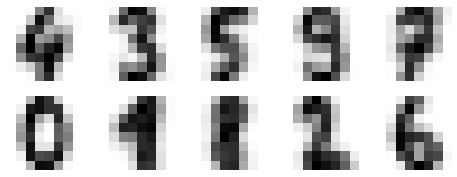

In [54]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3),
                       subplot_kw=dict(xticks=[], yticks=[]))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)

for axi, center in zip(ax.flat, centers):
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [99]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]  # this is a trick with the 
    # assumption that kmeans is tight most of the time

In [101]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.79354479688369506

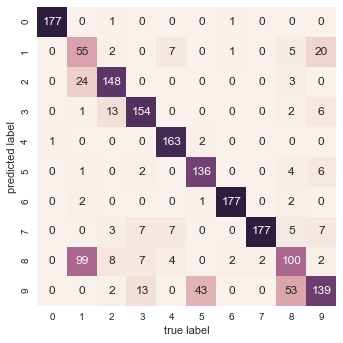

In [102]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
xticklabels=digits.target_names,
yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

__Let's use the t-distributed stochastic
neighbor embedding (t-SNE) algorithm to preprocess the data before performing k-means.__

In [110]:
from sklearn.manifold import TSNE

# project the data
tsne = TSNE(n_components=2, init='pca', random_state=0)
digits_proj = tsne.fit_transform(digits.data) 


In [111]:
# compute clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)


labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
    # Compute the accuracy
accuracy_score(digits.target, labels)

0.80467445742904842

*that's about 80% without labels*

#### 2. k-means for color compression

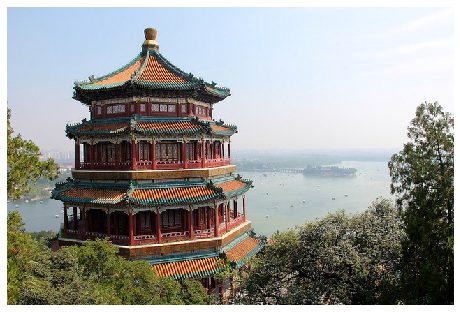

In [121]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [122]:
china.shape

(427, 640, 3)

__we can look view the set of pixels as cloud of points in a 3-D color space. We will then need to reshape as one long vector of 3-D pixels and let's rescape to a magnitude of one for each component__

In [134]:
data = china / 255.0
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

Let's look at this colors in this new space

In [148]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
        
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))
    
    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))
    
    fig.suptitle(title, size=20);

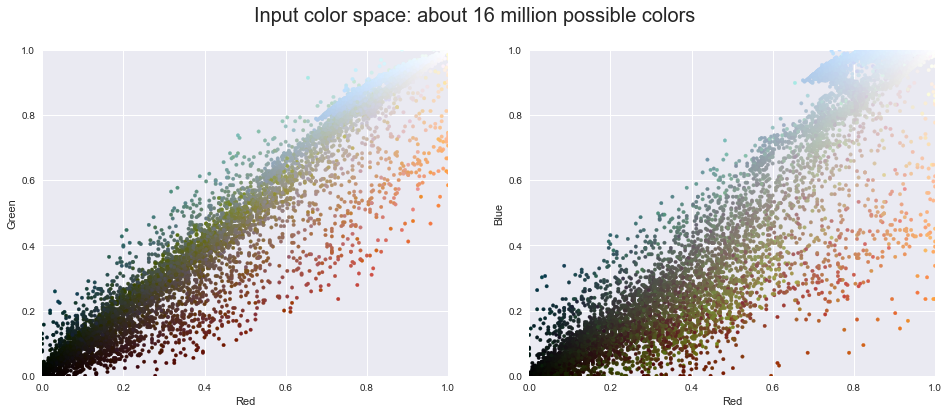

In [152]:
plot_pixels(data, title='Input color space: about 16 million possible colors')

Now let's reduce the 16 million colors to just 16 by clustering

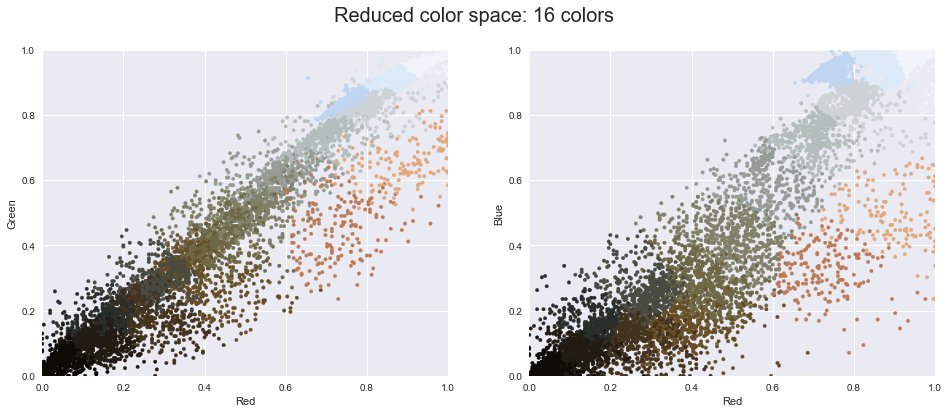

In [163]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
           title="Reduced color space: 16 colors")

Plotting the data in the picture space

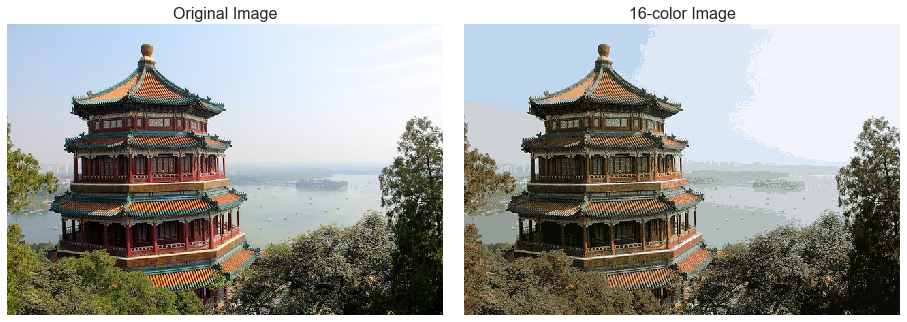

In [167]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                      subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);